In [78]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import re
import gc

cmap = plt.get_cmap('inferno')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cmap(np.linspace(0, 1, 10)))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', '+', 'H']

#plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=15)
plt.rc('lines', markersize=6)
plt.rc('lines', linewidth=2)
plt.rc('legend', loc='best')
plt.rc('legend', fontsize=8)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('font', family='serif')

In [3]:
wdir = '/home/robert/Datas/Collagen_fibril_zurik_ext/'
DFCS = {}

for fn in tqdm(os.listdir(wdir)):
    if not fn.endswith('.dat'):
        continue    
    
    file_path = os.path.join(wdir, fn)
    #print(file_path)

    # Define a regular expression pattern to match "ts_" followed by one or more digits
    pattern = r'ts_(\d+)'

    # Use re.findall() to find all matches in the file path
    numbers_after_ts = [match for match in re.findall(pattern, file_path)]

    ts = int(numbers_after_ts[0])

    df = pd.read_csv(file_path, sep = ' ')
    # Filtrar o DataFrame baseado nas condições especificadas
    df_core = df[(df['y'] >= -100) & (df['y'] <= 100)].copy()
    df_core['file_path'] = fn
    if ts in DFCS.keys():
        DFCS[ts].append(df_core)
    else:
        DFCS[ts] = [df_core]

    del df  # Descarte o DataFrame original
    gc.collect()  # Forçar a coleta de lixo



100%|██████████| 499/499 [03:03<00:00,  2.72it/s]


In [4]:
DFCS[2][0]

,id,uid,x,y,z,file_path
0,uid,0,0,-9,0,ts_2_seed_160.dat
1,uid,0,0,-8,0,ts_2_seed_160.dat
2,uid,0,0,-7,0,ts_2_seed_160.dat
3,uid,0,0,-6,0,ts_2_seed_160.dat
4,uid,0,0,-5,0,ts_2_seed_160.dat
...,...,...,...,...,...,...
539761,uid,29986,18,36,17,ts_2_seed_160.dat
539762,uid,29986,18,37,17,ts_2_seed_160.dat
539763,uid,29986,18,38,17,ts_2_seed_160.dat
539764,uid,29986,18,39,17,ts_2_seed_160.dat


In [77]:
file_path = '/home/robert/Datas/Collagen_fibril_zurik_ext/'
file_name = 'ts_2_seed_685.dat'

In [21]:
def cross_section_elements(df, y):

    filtered_df = df[df['y'] == y]
    x_values = filtered_df['x'].to_numpy()
    z_values = filtered_df['z'].to_numpy()

    return x_values, z_values

def calculate_rg(x_values, z_values):
    
    rgs = []
    Ns = []
    points = np.column_stack((x_values, z_values))

    #Define CM da CS
    r_cm = np.mean(points, axis=0)

    # Calcular a distância máxima do centro de massa ao ponto mais distante
    max_distance = np.max(np.sqrt(np.sum((points - r_cm)**2, axis=1)))

    # Definir as escalas usando a distância máxima
    scales = np.linspace(2, max_distance, num=30)
    #print(max_distance)

    for scale in scales:
  
        # Filtrar pontos cuja distância ao centro de massa é menor ou igual a scale
        distances_to_cm = np.sqrt(np.sum((points - r_cm)**2, axis=1))
        points_within_scale = points[distances_to_cm <= scale]

        if len(points_within_scale) > 0:
            # Calcular o centro de massa dos pontos dentro da escala
            #r_cm = np.mean(points_within_scale, axis=0)

            # Calcular o raio de giração
            #rg = np.sqrt(np.sum((points_within_scale - r_cm)**2) / len(points_within_scale))
            rgs.append(scale)
            Ns.append(len(points_within_scale))
            
    # Realizar o ajuste log-log
    log_rgs = np.log(rgs[3:])
    log_Ns = np.log(Ns[3:])
    
    return log_rgs, log_Ns

def power_law(x, a, b):
    return a * x + b


In [6]:
df = DFCS[2][0]
file_name = df['file_path'][0]
# Filtrar o DataFrame baseado nas condições especificadas
#df_core = df[(df['y'] >= -100) & (df['y'] <= 100) & (df['x'] >= -8) & (df['x'] <= 8) & (df['z'] >= -8) & (df['z'] <= 8)]

# CS's for fibril
cs_s = np.linspace(-99,99,11).astype(int) 
Df = []

for y in cs_s:
    #print(y)
    xv, zv = cross_section_elements(df,y)
    lrgs, lNs = calculate_rg(xv, zv)
    params, _ = curve_fit(power_law, lrgs, lNs)

    # Extrair a dimensão fractal do ajuste
    Df.append(params[0])  # A inclinação é a dimensão fractal
    dn = './'+file_name[:-4]+'_df.dat'
    #print(f'DF: {params[0]:.2f}')

np.savetxt(dn, Df,fmt='%.2f')

In [38]:
cs_s = np.linspace(-99,99,11).astype(int) 
#cs_s = [0]
for ts in sorted(DFCS.keys()):
    DF = []
    dn = './df_ts_'+str(ts)+'.dat'
    print(ts)
    for df in DFCS[ts]:
        #df = DFCS[2][0]..
        
        for y in cs_s:
            xv, zv = cross_section_elements(df,y)
            lrgs, lNs = calculate_rg(xv, zv)
            params, _ = curve_fit(power_law, lrgs, lNs)

            # Extrair a dimensão fractal do ajuste
            DF.append(params[0])  # A inclinação é a dimensão fractal
    print(len(DF))
    np.savetxt(dn, DF,fmt='%.2f')

2
550
8
550
16
539
64
550
128
550
512
550
1024
550
4096
550
8192
550
16384
550


In [17]:
fd = np.loadtxt('./df_ts_8192.dat')


In [18]:
fd.mean()

1.7233999999999998

In [80]:
# Implementing the calculation of mean and standard deviation
fdm = []
fdm_std = []
for ts in sorted(DFCS.keys())[:-1]:
    sts = str(ts)
    fn = './df_ts_%s.dat' % sts
    fd = np.loadtxt(fn)
    fdm.append(fd.mean())
    fdm_std.append(fd.std()/(len(fd)**(1/2)))

In [40]:
fdm

[1.4337636363636364,
 1.3886,
 1.3629499072356215,
 1.4893818181818181,
 1.5991090909090908,
 1.7510000000000001,
 1.7457818181818183,
 1.7375818181818183,
 1.7296727272727275,
 1.737]

In [ ]:
plt.scatter(x,y,'d-c')

In [52]:
fdm_std

[0.006298500220989848,
 0.007015784329072989,
 0.006406630521944317,
 0.0075805732176425205,
 0.009723867450600327,
 0.005805084690550416,
 0.005812103022805815,
 0.006070408871052929,
 0.006694204003664266,
 0.007236032427322048]

(0.3, 0.6)

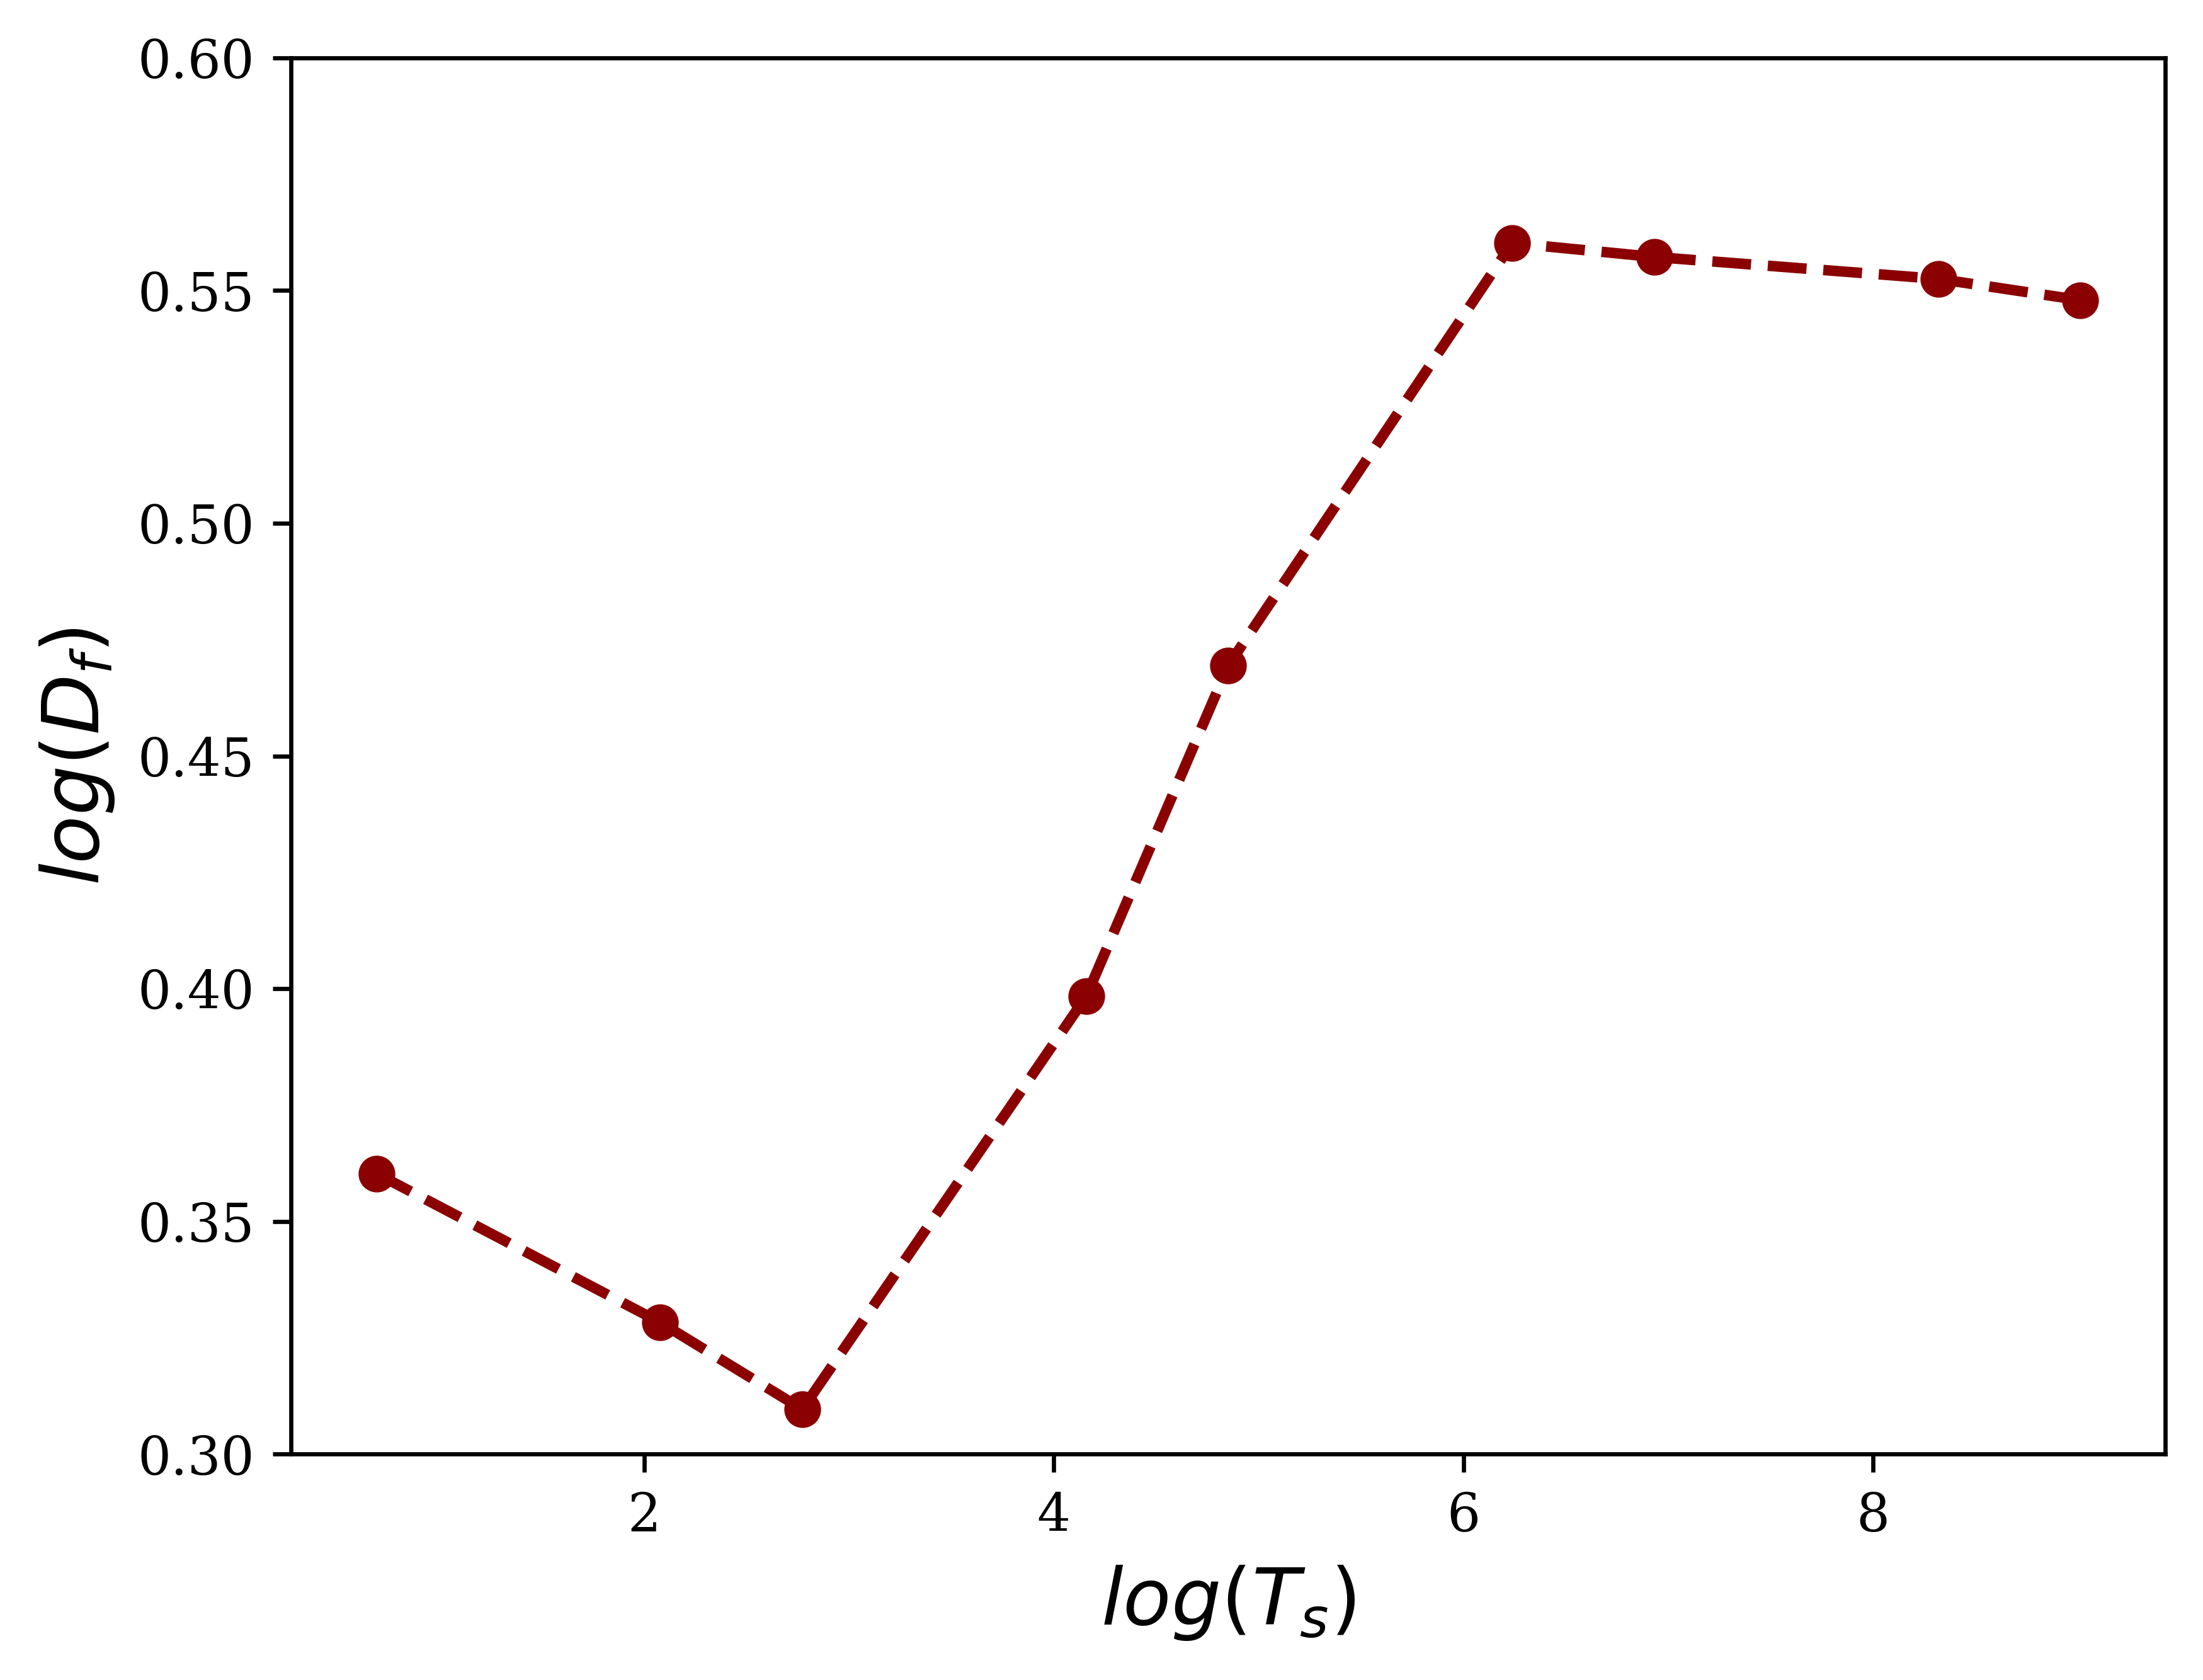

In [82]:
plt.figure(dpi = 600)
plt.plot(np.log(sorted(DFCS.keys())[:-1]),np.log(fdm),'o--', color = 'darkred')
plt.xlabel(r'$log(T_{s})$')
plt.ylabel(r'$log(D_{f})$')
plt.ylim(0.3,0.60)

In [90]:
type(lrgs)

numpy.ndarray

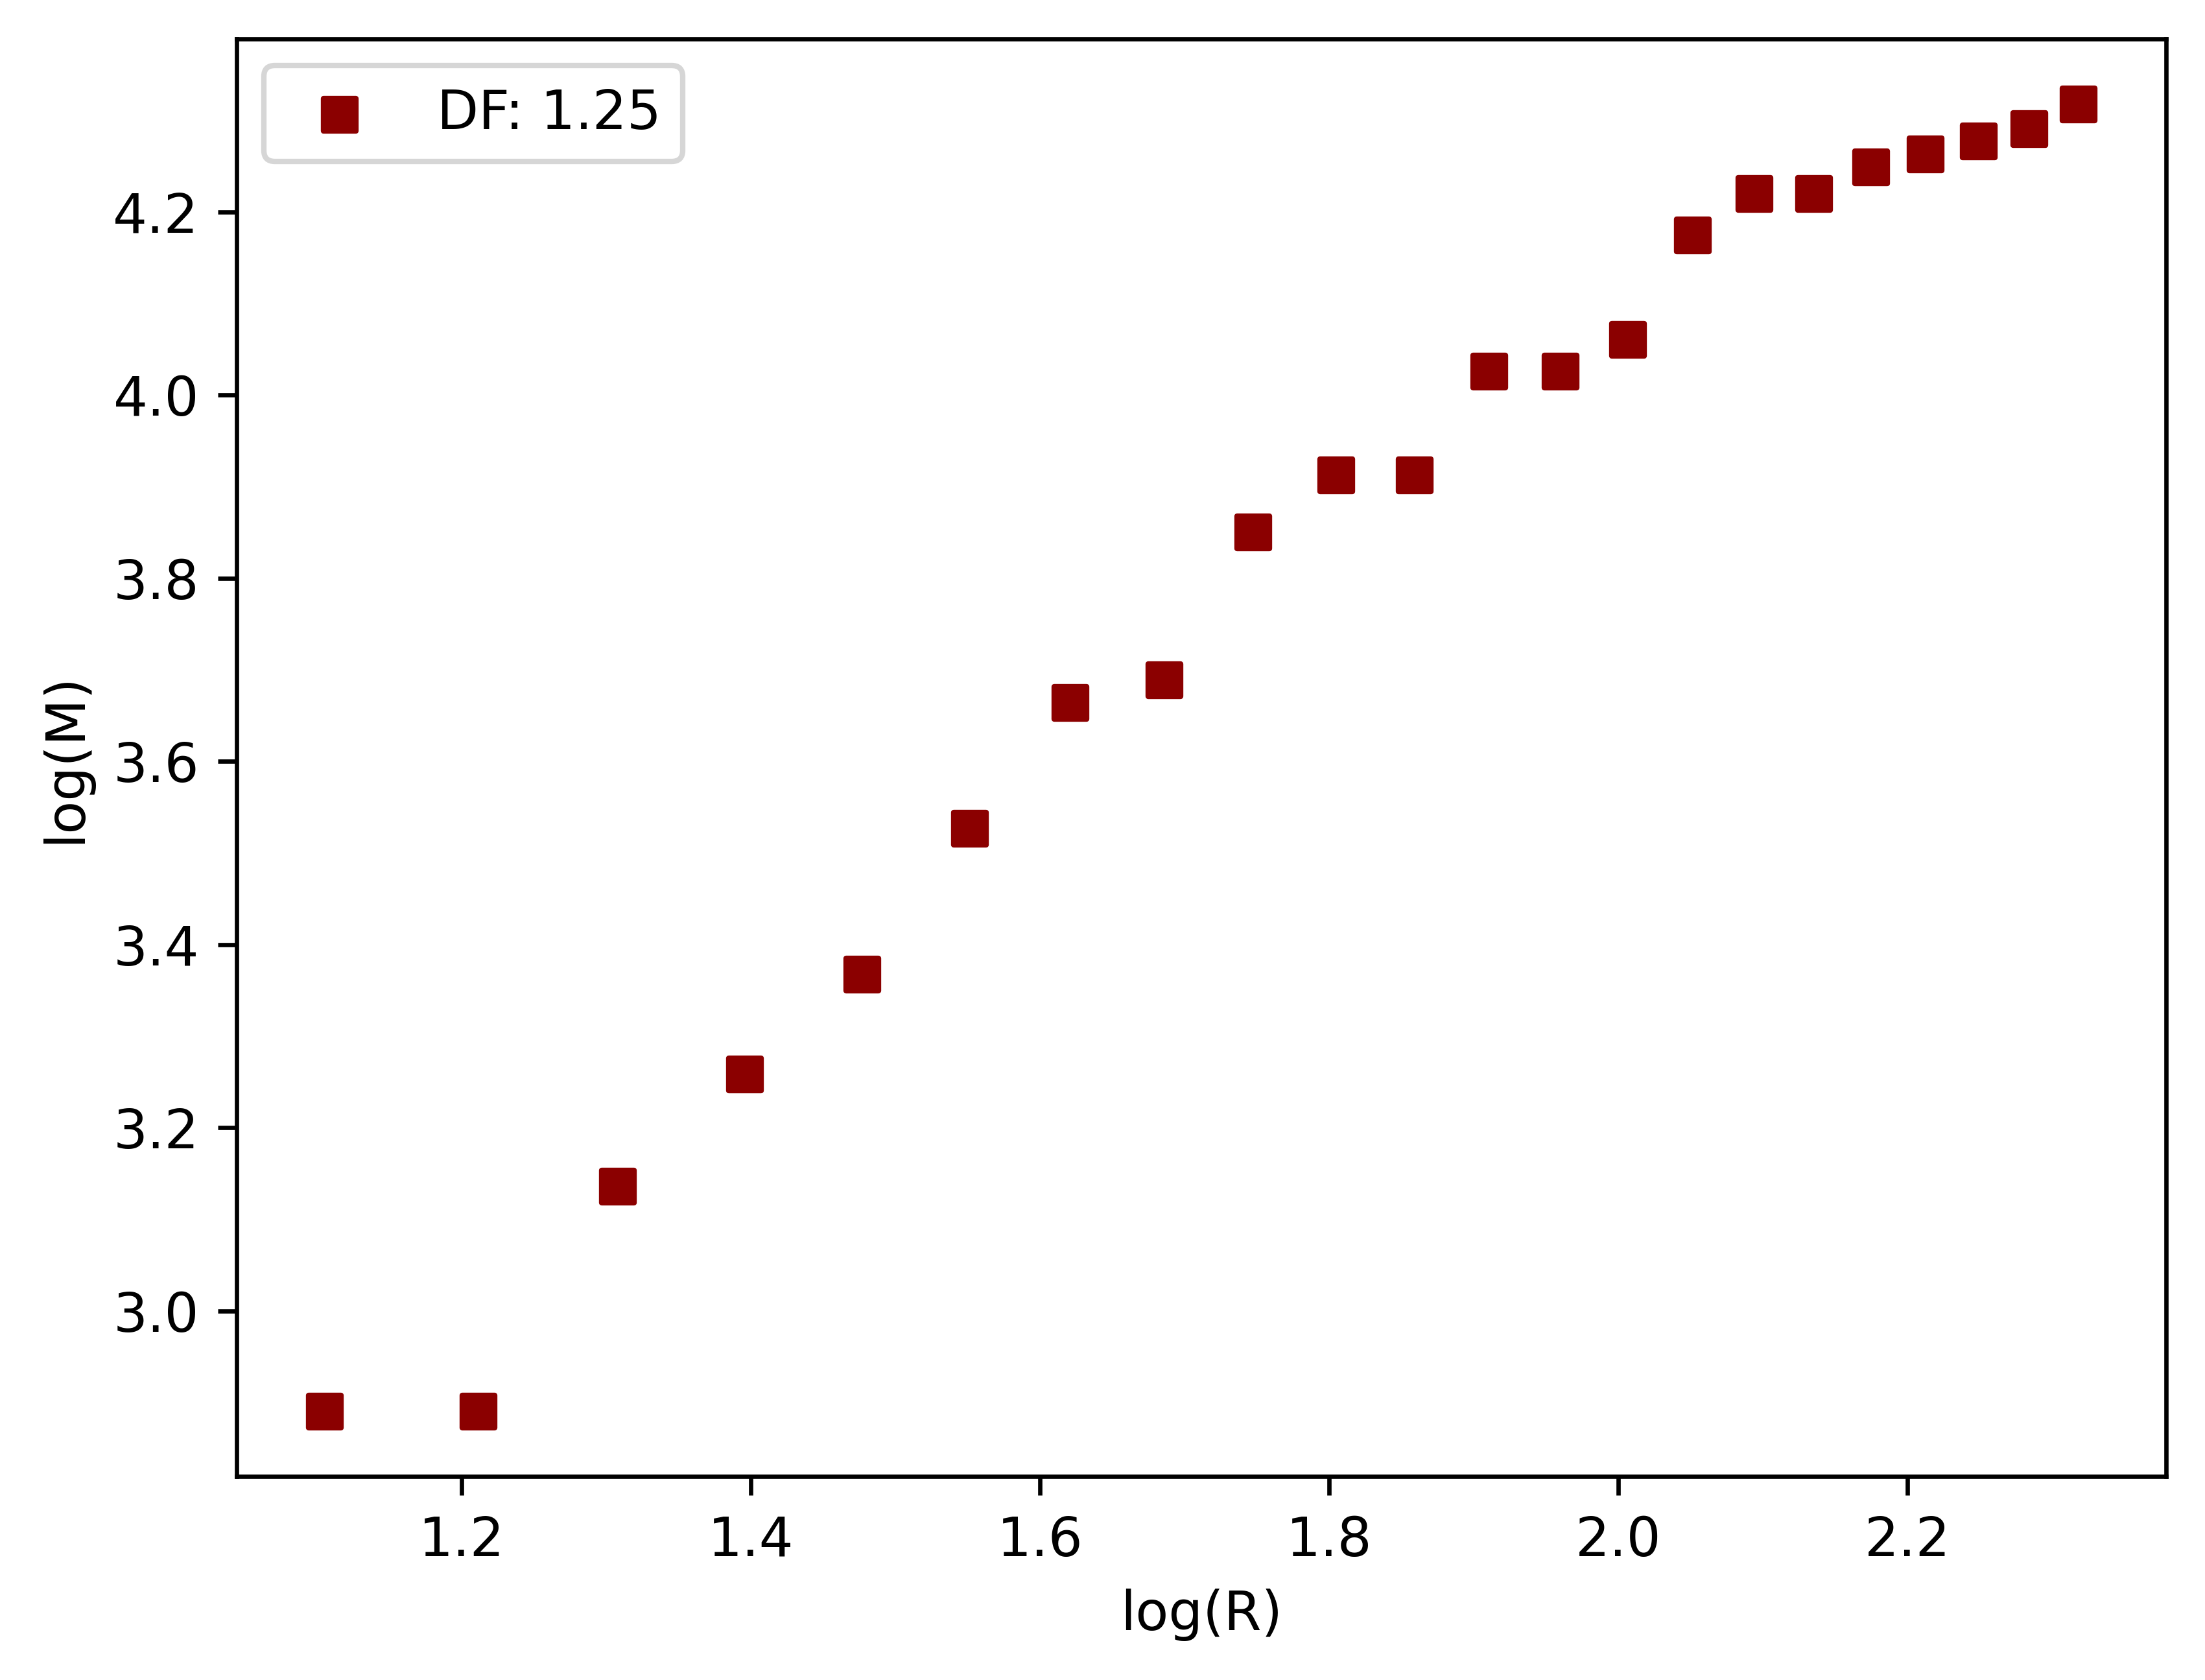

Text(0, 0.5, 'Z ')

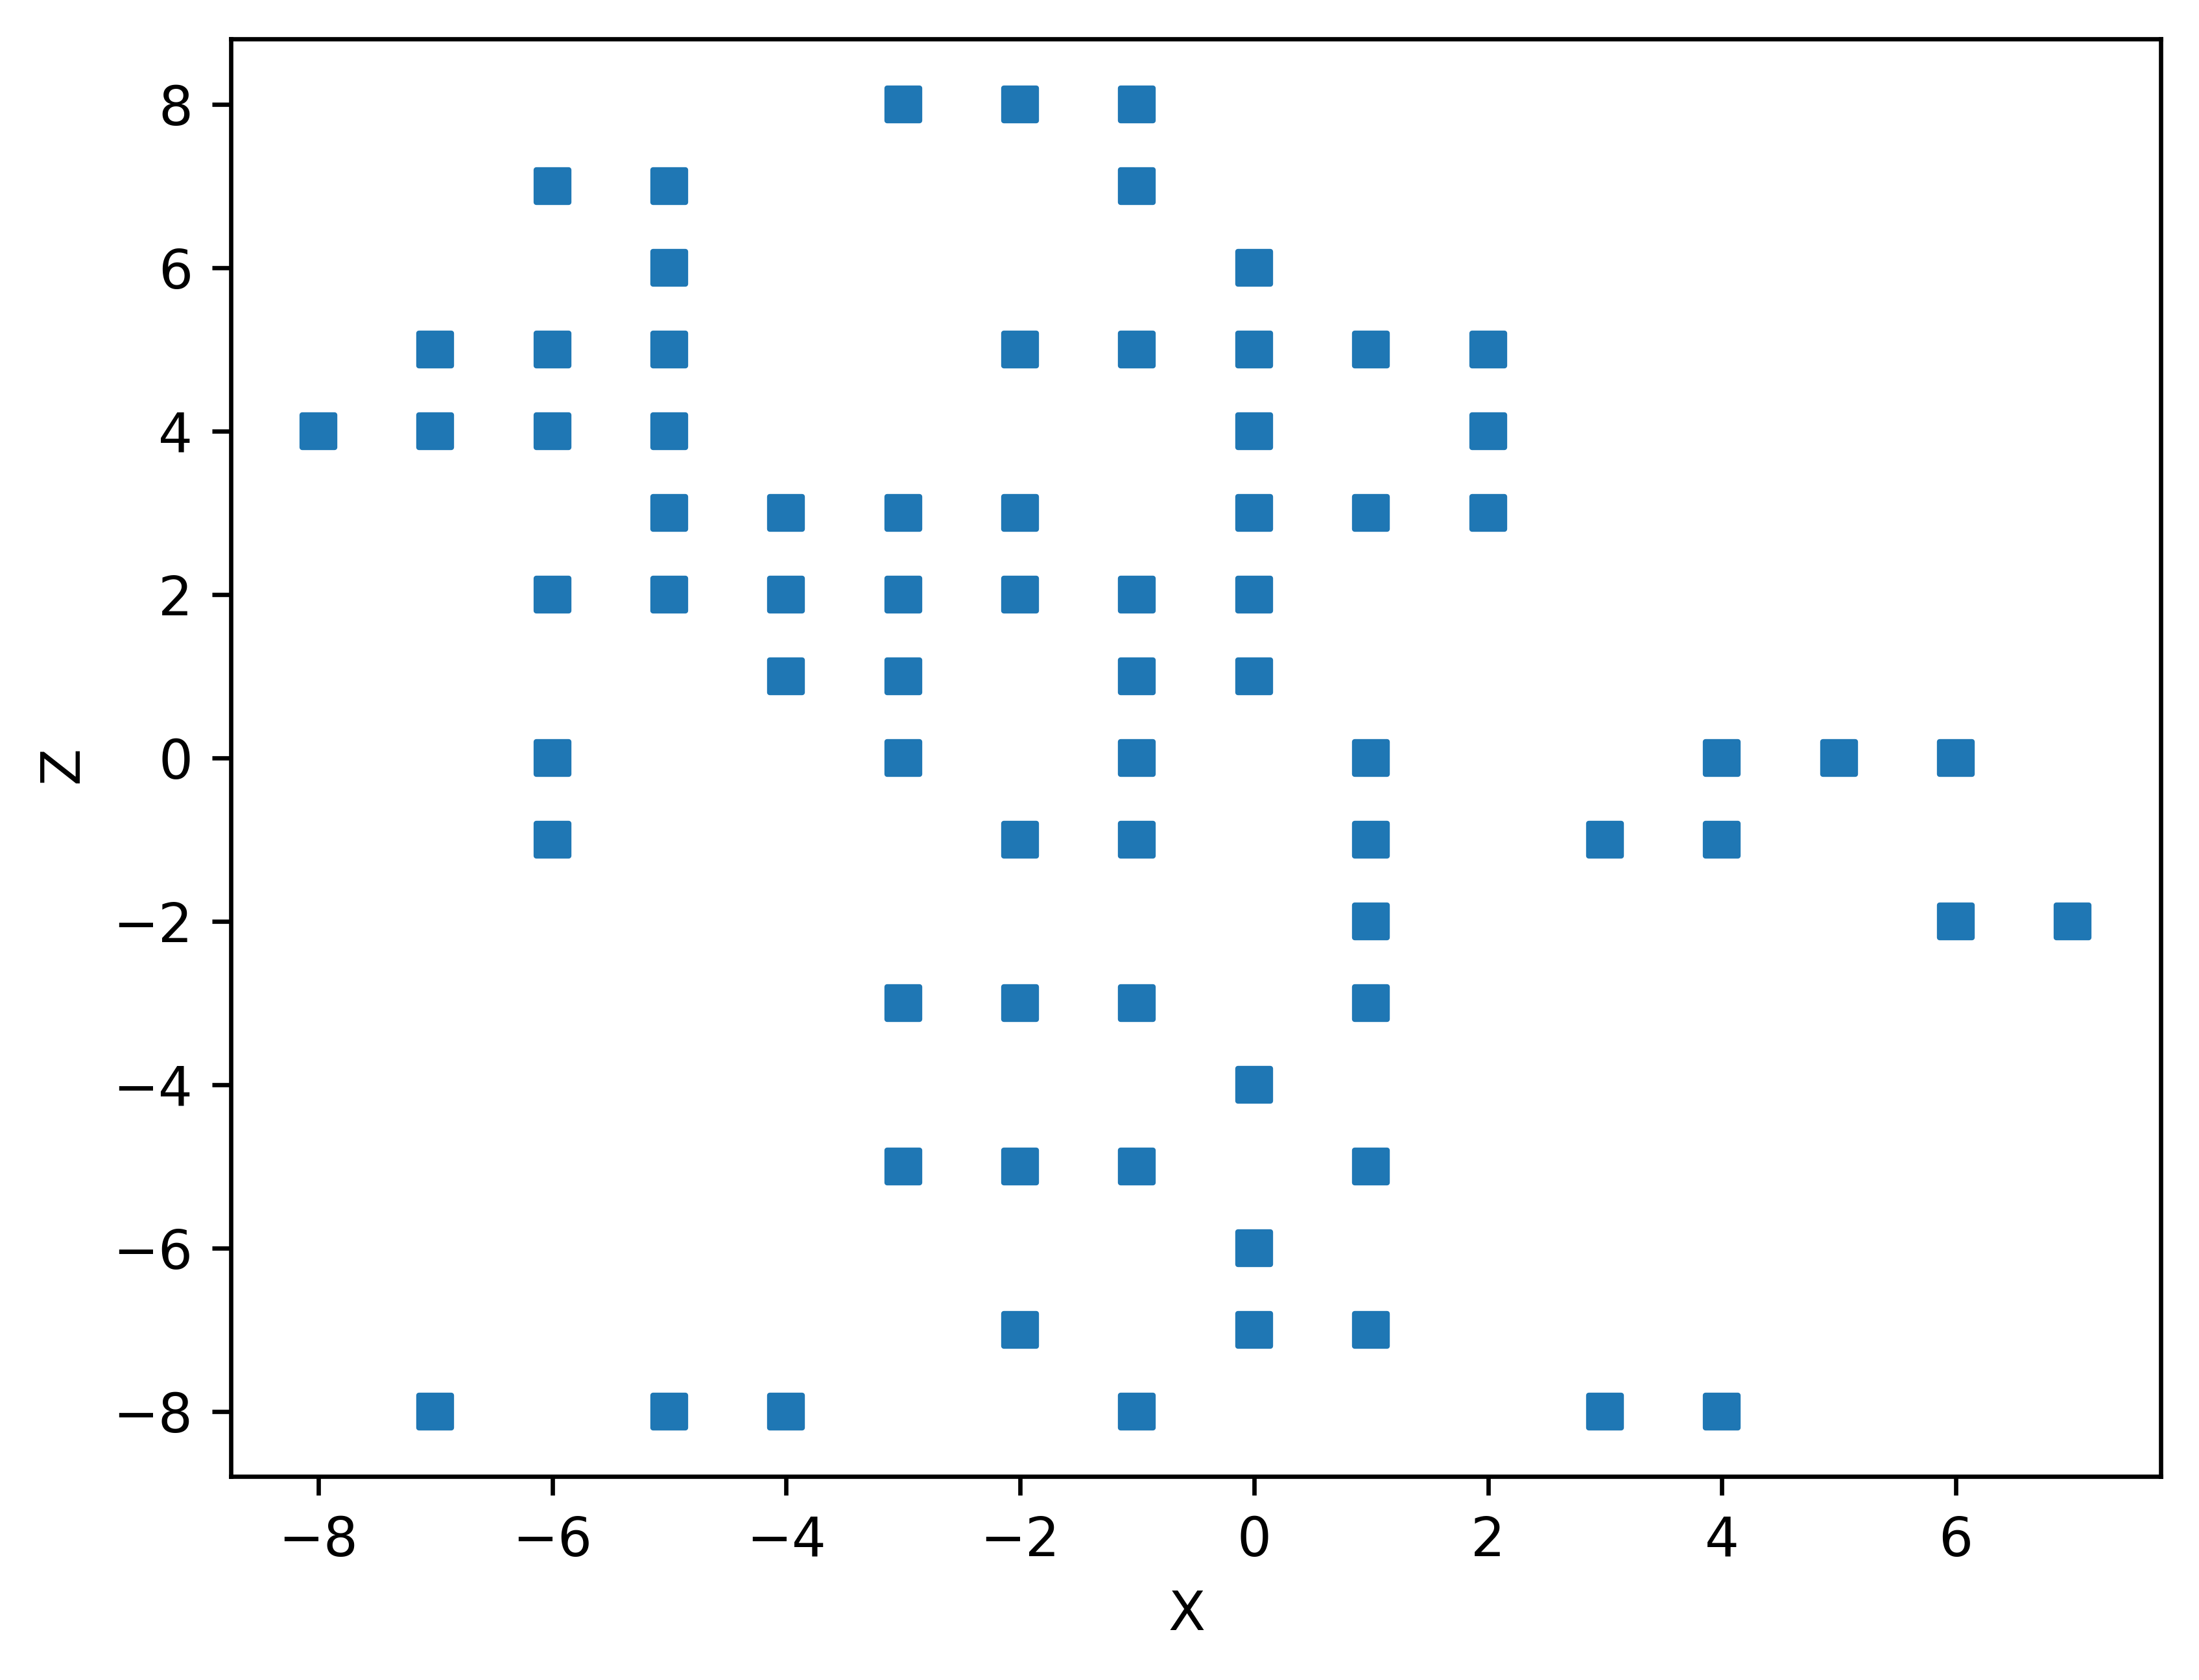

In [11]:
plt.figure(dpi = 600)
plt.scatter(lrgs,lNs, marker = 's', color = 'darkred', label = f'DF: {Df[-1]:.2f}')
plt.xlabel('log(R)')
plt.ylabel('log(M)')
plt.legend(loc = 'best')
plt.show()

# Plotting

plt.figure(dpi = 600)
plt.scatter(xv, zv, marker = 's')
plt.xlabel('X ')
plt.ylabel('Z ')

array([  2,   1,   2,   1,   2,   0,   0,   3,   0,   3,   3,  -1,   3,
        -1,   2,   7,  -1,   3,  -2,   6,  10,   1,   6,  -1,  -2,   7,
        -3,  -4,   0,   9, -10,   3,  -4, -10,   1,  -2,   8,  10,  11,
         5,  -9,  -8,   1,   4, -12,   4,   2,  -2,  -3, -11, -12,  11,
       -12,  -8,   9,  -4,  -2,  11, -12,  -8,  -9,  -9,  12,  -8,  12,
        -6,   4,  -7,  -5,   2,   4,  -3,  -1,   4,   8,  -7, -13,  -8,
         8, -12, -12,  15,   6, -10,   3, -13,  15, -14,  16, -16,  -8,
        13,   1,   3,  -9, -12,  -9,  13, -10,  -2,  17,  -3,  16,  17,
         0,   5,   4,   3,  12,  -4,  16,  11,  -7,  -9,  -4, -20,  -9,
         3,  18,  12,  -5,  -8,  -5,  -9, -17,  -6, -17,  -3,  -9, -16,
       -10,  -4,  -4,  12,  14,  15, -10,  16, -21, -18,  -3,  -5,  -4,
        -3, -15,   3,  14, -15, -14,  -5,  -7, -16, -15, -15,  12,  -3,
         2,  -4,  13, -10,  12,  -5,  20, -24,  13,  17, -22,  -1,   3,
       -18,  11, -21, -17,  12,  -8,   4,   1,   4,  -8, -24,   

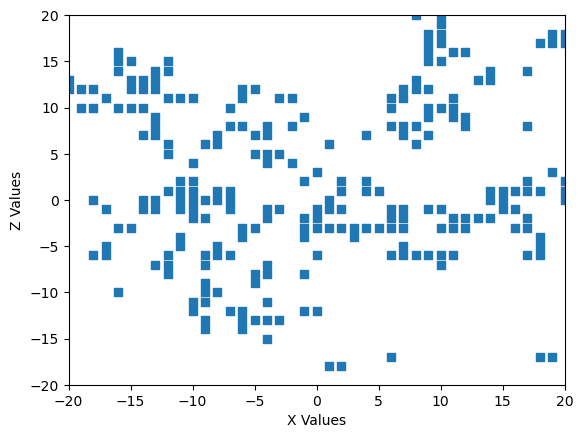

In [28]:
import matplotlib.pyplot as plt

# Plotting
plt.scatter(x_values, z_values, marker = 's')
plt.xlabel('X Values')
plt.ylabel('Z Values')

plt.xlim(-20,20)
plt.ylim(-20,20)
plt.show()


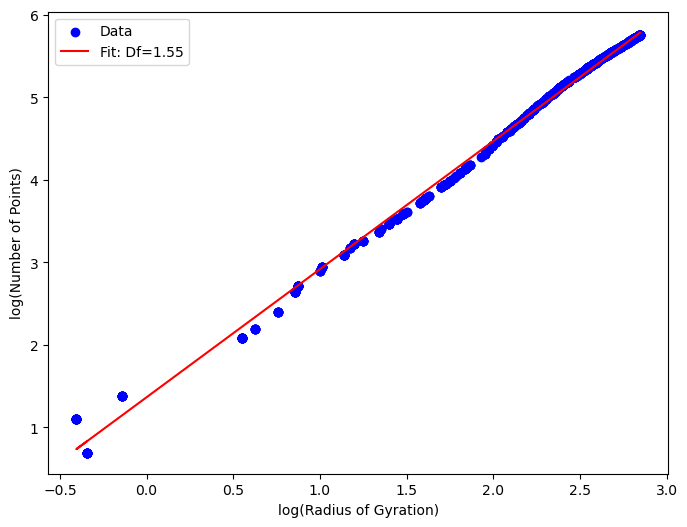

In [29]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Função para calcular o raio de giração para diferentes escalas
def calculate_rg(points, scales):
    rgs = []
    Ns = []
    for scale in scales:
        # Filtrar pontos dentro da escala atual
        points_within_scale = points[(points[:, 0]**2 + points[:, 1]**2) <= scale**2]

        if len(points_within_scale) > 0:
            # Calcular o centro de massa dos pontos dentro da escala
            r_cm = np.mean(points_within_scale, axis=0)

            # Calcular o raio de giração
            rg = np.sqrt(np.sum((points_within_scale - r_cm)**2) / len(points_within_scale))
            rgs.append(rg)
            Ns.append(len(points_within_scale))
    return rgs, Ns

# Função para ajuste de potência no log-log plot
def power_law(x, a, b):
    return a * x + b

# Simulação de dados fictícios
# Substitua x_values e z_values pelos seus dados reais

points = np.column_stack((x_values, z_values))

# Calcular o centro de massa dos pontos
r_cm = np.mean(points, axis=0)

# Calcular a distância máxima do centro de massa ao ponto mais distante
max_distance = np.max(np.sqrt(np.sum((points - r_cm)**2, axis=1)))

# Definir as escalas usando a distância máxima
scales = np.linspace(1, max_distance, num=1000)

# Calcular os raios de giração e o número de pontos correspondentes
rgs, Ns = calculate_rg(points, scales)

# Realizar o ajuste log-log
log_rgs = np.log(rgs[3:])
log_Ns = np.log(Ns[3:])
params, _ = curve_fit(power_law, log_rgs, log_Ns)

# Extrair a dimensão fractal do ajuste
Df = params[0]  # A inclinação é a dimensão fractal

# Plotar o ajuste
plt.figure(figsize=(8, 6))
plt.scatter(log_rgs, log_Ns, color='blue', label='Data')
plt.plot(log_rgs, power_law(log_rgs, *params), color='red', label=f'Fit: Df={Df:.2f}')
plt.xlabel('log(Radius of Gyration)')
plt.ylabel('log(Number of Points)')
plt.legend()
plt.show()

#print(f"Estimated fractal dimension: {Df:.2f}")


In [79]:
log_Ns

array([0.        , 0.        , 0.69314718, 0.69314718, 0.69314718,
       1.79175947, 2.56494936, 2.56494936, 2.56494936, 2.77258872,
       2.99573227, 3.17805383, 3.17805383, 3.33220451, 3.33220451,
       3.52636052, 3.61091791, 3.66356165, 3.66356165, 3.80666249,
       3.91202301, 3.95124372, 3.98898405, 4.04305127, 4.12713439,
       4.12713439, 4.18965474, 4.20469262, 4.20469262, 4.24849524,
       4.27666612, 4.27666612, 4.30406509, 4.35670883, 4.40671925,
       4.4308168 , 4.48863637, 4.48863637, 4.60517019, 4.66343909,
       4.71849887, 4.71849887, 4.75359019, 4.83628191, 4.88280192,
       4.89034913, 4.91265489, 4.94875989, 5.00394631, 5.04342512,
       5.04342512, 5.08140436, 5.12989871, 5.18178355, 5.19295685,
       5.22035583, 5.24174702, 5.29330482, 5.30330491, 5.33753808,
       5.36597602, 5.38907173, 5.40267738, 5.42495002, 5.43807931,
       5.45532112, 5.46383181, 5.47646355, 5.49306144, 5.49306144,
       5.50533154, 5.5174529 , 5.5174529 , 5.52146092, 5.53338

In [ ]:
fd = [ 1.52, 1.57, ]

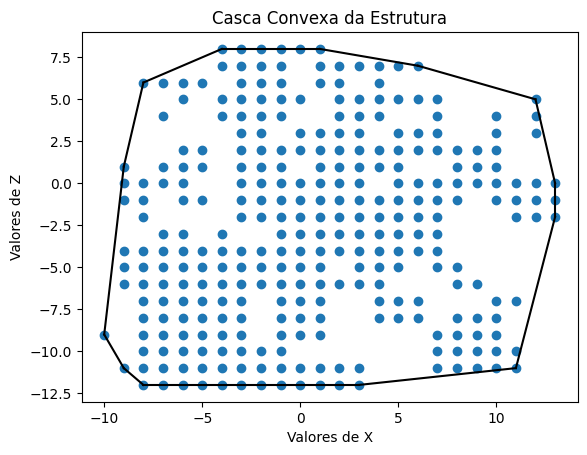

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull

# Carregar a imagem aqui ou obter os dados dos pontos (X, Z) diretamente
# Se os dados dos pontos estiverem disponíveis, eles podem ser usados diretamente.
# Assumindo que temos os pontos em arrays `x_values` e `z_values`

# Calcular a casca convexa
points = np.column_stack((x_values, z_values))  # Combina os valores X e Z em um conjunto de pontos
hull = ConvexHull(points)

# Plotar os pontos originais
plt.scatter(x_values, z_values)

# Plotar a casca convexa
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

# Adicionar títulos e rótulos se necessário
plt.title('Casca Convexa da Estrutura')
plt.xlabel('Valores de X')
plt.ylabel('Valores de Z')

# Mostrar o gráfico
plt.show()



In [32]:
!pip install shapely

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.0 MB/s eta 0:00:00a 0:00:01


In [33]:
from shapely.geometry import MultiPoint, Polygon
from shapely.ops import unary_union, polygonize
from scipy.spatial import Delaunay

# Assumindo que 'points' é um array de seus dados de pontos
points = np.column_stack((x_values, z_values))

# Calcula a triangulação de Delaunay
tri = Delaunay(points)
triangles = [points[simplice] for simplice in tri.simplices]

# Cria polígonos para as triângulos
polygons = [Polygon(triangle) for triangle in triangles]

# Cria um MultiPoint para representar os seus dados
multi_point = MultiPoint(points)

# Usa a união dos polígonos e interseção com o MultiPoint para criar o contorno
union = unary_union(polygons)
contour = [poly for poly in polygonize(union) if poly.intersects(multi_point)]

# Calcula o perímetro do contorno concavo
perimeter = contour[0].length if contour else 0

# Plotagem dos resultados
# Aqui você plotaria `contour[0]` sobre seus dados de pontos para visualizar o contorno
